<p style = 'font-size:40px'> <strong>Integrating Python and Oracle Databases</strong></p>

<p style = 'font-size:30px'> <strong> Introduction</strong> </p>

* <p style = 'font-size:20px'> The goal of this project is to demonstrate Python's capability to interact with Oracle Databases through the usage of cx_Oracle library. </p>
* <p style = 'font-size:20px'> To do this, I have simulated a situation in which I work for a hardware selling company that needs to get a variety of data about its performance. My role is to get access to the company's Oracle database in order to get the information demanded. </p>
* <p style = 'font-size:20px'> You can find the user's Entity Relationship Model (ERM) below: </p>

<img src='database.png'>

<p style = 'font-size:30px'> <strong>Project's tasks</strong> </p>

<p style = 'font-size:20px'> 1) Obtain the level of storage of each of the company's warehouses.  </p>
<p style = 'font-size:20px'> 2) List the most prolific salespeople. </p>
<p style = 'font-size:20px'> 3) Point out the product with most units sold for each of the company's customers. </p>
<p style = 'font-size:20px'> 4) Get the annual revenue per product category.  </p>
<p style = 'font-size:20px'> 5) Increase all CPU products price by 10%. </p>

<p style = 'font-size:30px'><strong>Connecting to the company's data</strong></p>

In [1]:
# Firstly we need to configure the Data Source Name (DSN).
# We are going to create a variable that stores all the informations related to our DSN.
# You must pass the host name, the port number and the service name of the database.

import cx_Oracle
dsn = cx_Oracle.makedsn('localhost.localdomain', 1521, service_name = 'orcl')

In [2]:
# Now, we are going to connect us to the user in which the demanded data can be found. Its name is 'OT'.
# If you are uncomfortable in with displaying the user's password in your code, you can use the getpass object from thet 
                                                                                                            #getpass library.

from getpass import getpass
password  = getpass('Write your database password:')

connection = cx_Oracle.connect('OT', password, dsn = dsn)

Write your database password: ······


<p style = 'font-size:30px'> <strong> Now let's get our data! </strong></p>

<p style = 'font-size:30px'> <em> Task 1 <span style = 'font-size:15px'>Obtain the storage level of each of the company's warehouses. </span></em> </p>

In [3]:
# Since the company has 8 warehouses, we are going to create a subplots figure. Each subplot will present the storage levels for
                                                                                                                    # each warehouse

# We also are going to create a list containg the position of each subplot in our figure.
l = [(i,j) for i in range(2) for j in range(4)]
print(l)

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3)]


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


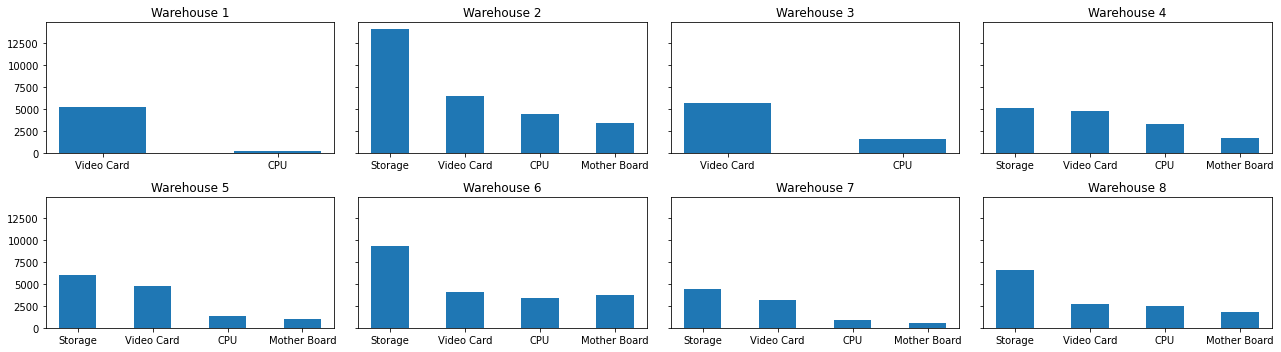

In [10]:
# Now, we are going to iterate over that list and plot the storage level for each product category available.
# We are going to use the enumerate method so we can take advantage of the list's indices to perform our queries.
import matplotlib.pyplot as plt
import pandas as pd
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(18,5), sharey=True)

for i, position in enumerate(l):
      
    query = f'''SELECT I.WAREHOUSE_ID, PC.CATEGORY_NAME, SUM(I.QUANTITY)
    FROM PRODUCT_CATEGORIES PC, PRODUCTS P, INVENTORIES I
    WHERE P.CATEGORY_ID=PC.CATEGORY_ID
    AND P.PRODUCT_ID=I.PRODUCT_ID
    AND WAREHOUSE_ID={i+1}
    GROUP BY I.WAREHOUSE_ID, PC.CATEGORY_NAME
    '''
    # Each time our query is run, pandas will create a DataFrame that contains the storage information of each warehouse.
    table = pd.read_sql(query, connection)
    # We are going to use the table's information to plot a chart for every single warehouse.
    ax[position].bar(table['CATEGORY_NAME'], table['SUM(I.QUANTITY)'],width=0.5)
    ax[position].set_title(f'Warehouse {i+1}') 

plt.tight_layout()
plt.savefig('task1.png')
fig.show()

<p style = 'font-size:30px'>  <em>Task 2 </em> <span style = 'font-size:15px'>List the most prolific salespeople. </span> </p>

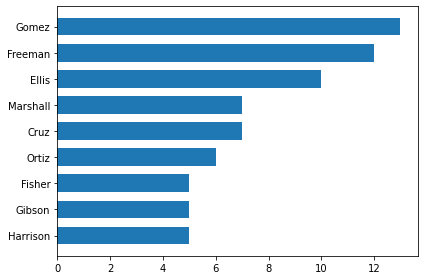

In [8]:
# This is a simple task: we must perform a join among the tables ORDERS and EMPLOYEES followed by a GROUP BY 
query = ''' SELECT E.LAST_NAME, COUNT(O.ORDER_ID) TOTAL_SALES
            FROM ORDERS O, EMPLOYEES E
            WHERE O.SALESMAN_ID = E.EMPLOYEE_ID
            GROUP BY O.SALESMAN_ID, E.LAST_NAME
            ORDER BY TOTAL_SALES ASC
            '''
# The pandas DataFrame obtained will contain the surname and the amount of sales made by a certain salesperson.
salesman = pd.read_sql(query, connection)
y = salesman['LAST_NAME']
x = salesman['TOTAL_SALES']
plt.barh(y,x, height = 0.68)
plt.tight_layout()
plt.savefig('task2')

<p style = 'font-size:30px'> <em> Task 3 </em> <span style = 'font-size:15px'>Point out the product category with most units sold for each of the company's customers. </span>  </p>

In [22]:
# This task will demand us a big join operation in order to unite the companies' names, the product categories they consume and the
# total quantity bought in a single table.
# The query below will give us the name of each of the company's customers along with the products categories they buy and their
                                                                                                # respective quantity 
query = '''SELECT C.NAME, PC.CATEGORY_NAME, SUM(OI.QUANTITY) TOTAL_QUANTITY
FROM ORDER_ITEMS OI, ORDERS O, CUSTOMERS C, PRODUCTS P, PRODUCT_CATEGORIES PC
WHERE OI.ORDER_ID=O.ORDER_ID
AND O.CUSTOMER_ID = C.CUSTOMER_ID
AND OI.PRODUCT_ID = P.PRODUCT_ID  
AND P.CATEGORY_ID=PC.CATEGORY_ID
GROUP BY (C.NAME, PC.CATEGORY_NAME)
ORDER BY C.NAME
'''

c_o_info = pd.read_sql(query, connection, index_col=['NAME'])
# We need to perform a second group operation on pandas to get the data demanded. This would be simpler than making the whole process
                                                                                                                # on Oracle.
#c_o_info.groupby([c_o_info.index])['CATEGORY_NAME','TOTAL_QUANTITY'].max()
c_o_info.groupby(level = 0)['CATEGORY_NAME','TOTAL_QUANTITY'].max()


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


,CATEGORY_NAME,TOTAL_QUANTITY
NAME,,
AECOM,Storage,287
AbbVie,Video Card,827
Abbott Laboratories,Video Card,503
Aflac,Video Card,1351
Alcoa,Video Card,1512
American Electric Power,Storage,500
AutoNation,Video Card,823
AutoZone,Video Card,235
Baker Hughes,Video Card,207


<p style = 'font-size:30px'> <em> Task 4</em> <span style = 'font-size:15px'>Get the annual revenue per product category. </span> </p>

,ORDER_DATE,CATEGORY_NAME,REVENUE
0,2013,CPU,243447.75
1,2013,Storage,270820.16
2,2015,CPU,3365931.32
3,2015,Mother Board,598459.65
4,2015,Storage,2170320.55
5,2015,Video Card,2689065.10
6,2016,CPU,8602324.95
7,2016,Mother Board,2101448.44
8,2016,Storage,5997806.79
9,2016,Video Card,4788025.92


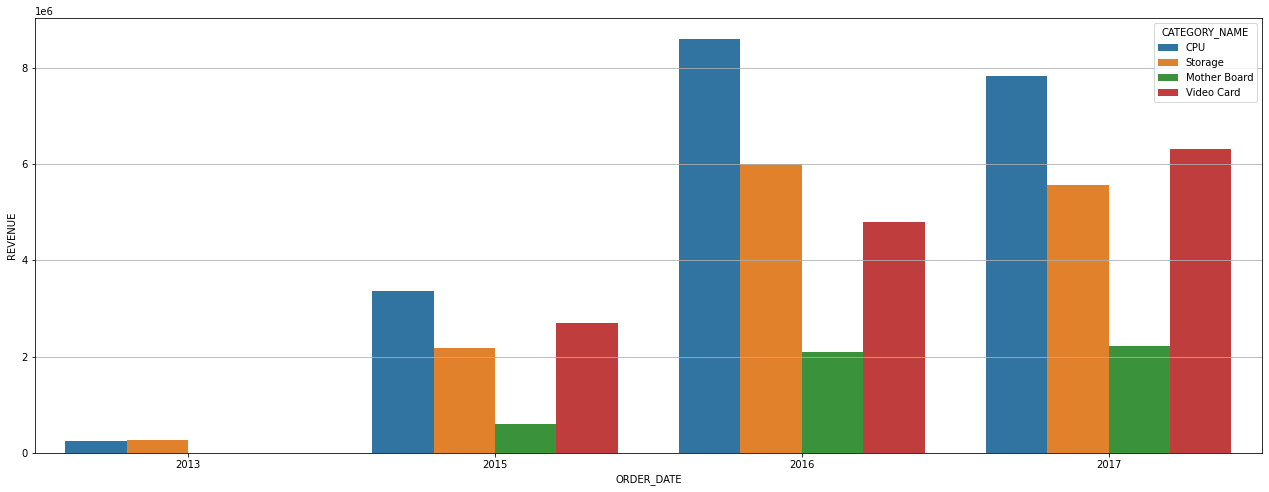

In [29]:
# This query is a bit tricky: firstly, we need to perform a join operation that returns a daily report on the revenue obtained from
# the sellings of each product categories.
query = ''' SELECT O.ORDER_DATE, PC.CATEGORY_NAME, SUM(OI.UNIT_PRICE * OI.QUANTITY) REVENUE
            FROM ORDER_ITEMS OI, ORDERS O, PRODUCTS P, PRODUCT_CATEGORIES PC
            WHERE PC.CATEGORY_ID = P.CATEGORY_ID
            AND P.PRODUCT_ID = OI.PRODUCT_ID
            AND O.ORDER_ID = OI.ORDER_ID
            GROUP BY PC.CATEGORY_NAME, O.ORDER_DATE
            ORDER BY O.ORDER_DATE
'''


revenue = pd.read_sql(query, connection,parse_dates = True, index_col = ['ORDER_DATE'])
# To get the annual data, we have to convert the DataFrame's index to a Period with yearly frequency.
revenue.index = revenue.index.to_period('Y')
# After it, we must perform a groupby operation on pandas to sum each product categories revenue based on the year shown in the index.
revenue = revenue.groupby([revenue.index, 'CATEGORY_NAME']).sum()
revenue.reset_index(level = [0,1], inplace = True)
display(revenue)

import seaborn as sns
plt.figure(figsize=(22,8))
#a.reset_index(inplace = True)
sns.barplot(data=revenue, x='ORDER_DATE', hue='CATEGORY_NAME', y='REVENUE')

plt.grid(axis='y')

<p style = 'font-size:30px'> Task 5 <span style = 'font-size:15px'> Increase all CPU products price by 10%.</span> </p>

In [42]:
# This particular query will demand us to create a cursor in order to update to CPU products' prices.
# Firstly, I'll present you a DataFrame containing all the CPU products prices.
query = ''' SELECT P.PRODUCT_ID, PC.CATEGORY_NAME, P.LIST_PRICE
            FROM PRODUCTS P, PRODUCT_CATEGORIES PC
          WHERE P.CATEGORY_ID=PC.CATEGORY_ID
            AND PC.CATEGORY_NAME='CPU' '''
cpu = pd.read_sql(query, connection)

# I am also going to create a new column showing how each price of the LIST_PRICE column should look like after our UPDATE operation.
# You can see that the CPU_NEW column contains the new CPU prices the company aims to settle.
cpu.eval('CPU_NEW=LIST_PRICE*1.1', inplace= True)
cpu.round(2)

,PRODUCT_ID,CATEGORY_NAME,LIST_PRICE,CPU_NEW
0,228,CPU,3410.46,3751.51
1,248,CPU,2774.98,3052.48
2,249,CPU,2660.72,2926.79
3,2,CPU,2554.99,2810.49
4,45,CPU,2501.69,2751.86
...,...,...,...,...
65,124,CPU,594.99,654.49
66,72,CPU,589.99,648.99
67,155,CPU,588.95,647.85
68,80,CPU,564.89,621.38


In [44]:
# Let's create the cursor and perform the UPDATE statement:
cursor = connection.cursor()
command = '''UPDATE PRODUCTS 
    SET LIST_PRICE =  LIST_PRICE * 1.1
    WHERE PRODUCT_ID IN 
    (SELECT P.PRODUCT_ID
            FROM PRODUCTS P, PRODUCT_CATEGORIES PC
            WHERE P.CATEGORY_ID=PC.CATEGORY_ID
            AND PC.CATEGORY_NAME='CPU')'''

cursor.execute(command)

In [68]:
# Now, let's verify if the new LIST_PRICE prices are in accordance with the ones from CPU_NEW.
query = ''' SELECT P.PRODUCT_ID, PC.CATEGORY_NAME, P.LIST_PRICE
            FROM PRODUCTS P, PRODUCT_CATEGORIES PC
            WHERE P.CATEGORY_ID=PC.CATEGORY_ID
            AND PC.CATEGORY_NAME='CPU' '''
new_cpu = pd.read_sql(query, connection)

# You can see that the new LIST_PRICE values match the ones from CPU_NEW from the 'cpu' DF. 
new_cpu['LIST_PRICE']

0     3751.51
1     3052.48
2     2926.79
3     2810.49
4     2751.86
       ...   
65     654.49
66     648.99
67     647.85
68     621.38
69     610.49
Name: LIST_PRICE, Length: 70, dtype: float64